In [1]:
using PhyloNetworks, InPhyNet, CSV, DataFrames, DelimitedFiles, StatsBase, Random, Combinatorics, QuartetNetworkGoodnessFit
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/helpers/data-simulation.jl") # get_descendant_leaves

rm_suppress (generic function with 2 methods)

In [2]:
best_species_tree = readTopology("okp_data/estimated_species_tree.tre");
est_gts = readMultiTopology("okp_data/Best.33.FAA.tre");

In [8]:
uq_taxon_names = Set()
min_taxa = Int64(1e8)
max_taxa = -1
for gt in est_gts
    iter_taxa = Set(tipLabels(gt))
    union!(uq_taxon_names, iter_taxa)
    min_taxa = min(min_taxa, length(iter_taxa))
    max_taxa = max(max_taxa, length(iter_taxa))
end

println(
    """
    Total unique taxa: $(length(uq_taxon_names))
    Range: $(min_taxa) - $(max_taxa)
    """
)

Total unique taxa: 1178
Range: 38 - 1131



In [19]:
# Are `est_gts` and `best_species_tree` on the same set of taxa? Yes!
sort(tipLabels(best_species_tree)) ==
    sort(unique(reduce(vcat, [tipLabels(gt) for gt in est_gts])))

true

In [3]:
# Do all pairs of taxa appear in at least 1 gene tree together? Yes!
all_taxa = tipLabels(best_species_tree)
gt_labels = [tipLabels(gt) for gt in est_gts]
leaf_map = Dict(name => j for (j, name) in enumerate(all_taxa))
n_pairwise_combos = zeros(Int64, length(all_taxa), length(all_taxa)) .- 1

for gt in est_gts
    for (t1, t2) in combinations(tipLabels(gt), 2)
        n_pairwise_combos[leaf_map[t1], leaf_map[t2]] += 1
    end
end

n_pairwise_combos = n_pairwise_combos[n_pairwise_combos .!= -1]
@info "Min:  $(minimum(n_pairwise_combos))"
@info "Mean: $(mean(n_pairwise_combos))"
@info "Max:  $(maximum(n_pairwise_combos))"

InterruptException: InterruptException:

In [3]:
annot = readdlm("all_okp_data/scripts/hypo-test/updated_annotations.txt", '\t', header=true)

# Trim pesky whitespace...
for (idx, _) in enumerate(annot[1]) annot[1][idx] = strip(annot[1][idx]) end
for (idx, _) in enumerate(annot[2]) annot[2][idx] = strip(annot[2][idx]) end

annot_df = DataFrame(annot[1], annot[2][1,:])

# Remove taxa that are not in the main astral tree that was estimated, i.e. taxa that were not used in the main analyses
deleteat!(annot_df, findall(r -> !(r.Code in tipLabels(best_species_tree)), eachrow(annot_df)))

0   # don't want to see the DataFrame every time...

0

---

# Gymnosperms

Discordance between the following clades:
1. Other (outgroup - using Rhodophytes aka Rhodophyta for this)
2. Gnetales         (3 taxa)
3. Pinaceae         (15 taxa)
4. Other Pinidae    (73 - 14 = 59 taxa)

My best inference is that Pinales can be reasonably described as the union of two sets: Pinaceae and other Pinidae. So, we have 80 total Pinales, 15 of which are Pinaceae specifically, so the "Other Pinidae" group has 65 members.

In [15]:
# Taxa counts
(
    sum(annot_df[:,"Classification1"] .== "Gnetales"),
    sum(annot_df[:,"Confer_relationships"] .== "Pinaceae"),
    sum(annot_df[:,"Classification1"] .== "Pinales"),
    sum(annot_df[:,"Classification1"] .== "Rhodophyta"),

    sum(annot_df[:,"Very_brief_Classification"] .== "Gymnos"),
    sum(annot_df[:,"brief_Classification"] .== "Lycophytes"),
    sum(annot_df[:,"Equisetum_sister"] .== "Polypodiidae"),
    # AMBORELLA (MEMBER OF ANA GRADE):  URDJ
    # NYMPHAEALES:                      PZRT, WTKZ
    # AUSTROBAILEYALES:                 FZJL, NWMY, ROAP, VZCI
    # sum(annot_df[:,"Very_brief_Classification"] .== "Gymnos")
)

(3, 15, 73, 29, 82, 22, 63)

### Subset decomposition

1. Infer the tree of blobs on all gymnosperms + all ANA grade (1 amborella + 2 nymphaeales + 3 austrobaileyales) + 3 random ferns + 3 random lycophytes
2. Identify cycles
3. Use that w/ the "cheating" style decomposition method to perform subset decomps

In [15]:
relevant_taxa = [
    row["Code"] for row in eachrow(annot_df) if row["Very_brief_Classification"] == "Gymnos" ||
                                                row["Code"] in ["URDJ", "PZRT", "WTKZ", "FZJL", "NWMY", "ROAP", "VZCI"]
]
polypod_taxa = [row["Code"] for row in eachrow(annot_df) if row["Equisetum_sister"] == "Polypodiidae"]
lycoph_taxa = [row["Code"] for row in eachrow(annot_df) if row["brief_Classification"] == "Lycophytes"]

Random.seed!(42)
relevant_taxa = [relevant_taxa; sample(polypod_taxa, 3, replace=false); sample(lycoph_taxa, 3, replace=false)]

94-element Vector{SubString{String}}:
 "Pinta_v2.0"
 "GTHK"
 "TOXE"
 "VDAO"
 "AQFM"
 "AREG"
 "AWQB"
 "DZQM"
 "GAMH"
 "GGEA"
 ⋮
 "WLIC"
 "XZUY"
 "SGTW"
 "RICC"
 "MTGC"
 "NWWI"
 "JKAA"
 "Selmo_v1.0"
 "GAON"

In [ ]:
pruned_gts = [
    pruneTruthFromDecomp(gt, relevant_taxa) for gt in est_gts if length(intersect(tipLabels(gt), relevant_taxa)) >= 4
];
writeMultiTopology(pruned_gts, "ToB_inference/pruned_gts.tre")

In [12]:
tob = readTopology("ToB_inference/gymno_tob-a001-b099.tre")
blob_centers = [node for node in tob.node if length(node.edge) > 3]
@show length(blob_centers)

[leaf.name for leaf in get_descendant_leaves(blob_centers[3])]

length(blob_centers) = 3


35-element Vector{String}:
 "SGTW"
 "WLIC"
 "XZUY"
 "KAWQ"
 "GNQG"
 "GGEA"
 "AWQB"
 "VSRH"
 "GAMH"
 "AREG"
 ⋮
 "VZCI"
 "NWMY"
 "FZJL"
 "NPRL"
 "WVWN"
 "IOVS"
 "VDAO"
 "TOXE"
 "GTHK"

ToB blobs:
- 27: ["ZQVF", "NRXL", "QFAE", "HBGV", "GMHZ", "OXGJ", "FHST", "XMGP", "CGDN", "FRPM", "XQSG", "BUWV", "QNGJ", "UEVI", "VFYZ", "NKIN", "YYPE", "OVIJ", "ETCJ", "RMMV", "JDQB", "IFLI", "GKCZ", "AUDE", "AIGO", "QSNJ", "XIRK"]
- 35: ["SGTW", "WLIC", "XZUY", "KAWQ", "GNQG", "GGEA", "AWQB", "VSRH", "GAMH", "AREG", "JUWL", "AQFM", "RICC", "NWWI", "MTGC", "Selmo_v1.0", "JKAA", "GAON", "IIOL", "JBND", "MFTM", "DZQM", "Pinta_v2.0", "URDJ", "WTKZ", "PZRT", "VZCI", "NWMY", "FZJL", "NPRL", "WVWN", "IOVS", "VDAO", "TOXE", "GTHK"]

27 and 35 are too large, so we split both of them in half such that each split has >=1 taxa from each blob clade (more or less - taxa that form their own clade on the blob only appear in one subset):
- 35 --> [17, 18]
- 27 --> [13, 14]

In [39]:
set17 = ["SGTW", "GNQG", "KAWQ", "AWQB", "VSRH", "JUWL", "RICC", "GAON", "JKAA", "DZQM", "Pinta_v2.0", "URDJ", "WTKZ", "PZRT", "IOVS", "VDAO", "TOXE"]
set18 = ["XZUY", "WLIC", "GGEA", "AQFM", "AREG", "GAMH", "NWWI", "MTGC", "Selmo_v1.0", "IIOL", "JBND", "MFTM", "FZJL", "NWMY", "VZCI", "NPRL", "WVWN", "GTHK"]

set13 = ["ZQVF", "NRXL", "QFAE", "FHST", "XMGP", "FRPM", "BUWV", "VFYZ", "YYPE", "ETCJ", "RMMV", "IFLI", "QSNJ"]
set14 = ["XIRK", "HBGV", "GMHZ", "OXGJ", "CGDN", "XQSG", "QNGJ", "UEVI", "NKIN", "OVIJ", "JDQB", "GKCZ", "AUDE", "AIGO"]

14-element Vector{String}:
 "XIRK"
 "HBGV"
 "GMHZ"
 "OXGJ"
 "CGDN"
 "XQSG"
 "QNGJ"
 "UEVI"
 "NKIN"
 "OVIJ"
 "JDQB"
 "GKCZ"
 "AUDE"
 "AIGO"

In [48]:
# `relevant_taxa`
blob_subsets = [set13, set14, set17, set18]

decomp_taxa = deepcopy(relevant_taxa)
for subset in blob_subsets
    for taxon in subset
        if findfirst(t -> t == taxon, decomp_taxa) === nothing @show taxon end
        deleteat!(decomp_taxa, findfirst(t -> t == taxon, decomp_taxa))
    end
end

sateI_subsets = sateIdecomp(pruneTruthFromDecomp(best_species_tree, decomp_taxa), 10, 30)
sateI_subsets = [sateI_subsets; blob_subsets]
L = [length(s) for s in sateI_subsets]
@info "$(length(sateI_subsets)) subsets, min=$(minimum(L)), max=$(maximum(L)), mean=$(mean(L))"

┌ Info: 6 subsets, min=13, max=19, mean=15.666666666666666
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/analysis.ipynb:15


In [51]:
# Write pruned gene trees and species tree to files for SNaQ
for (subset_idx, subset) in enumerate(sateI_subsets)
    pruned_gts = [pruneTruthFromDecomp(gt, subset) for gt in est_gts if length(intersect(tipLabels(gt), subset)) >= 4]
    pruned_tre0 = pruneTruthFromDecomp(best_species_tree, subset)

    subset_dir = "subset_data/gymnosperms/subset$(subset_idx)"
    if !isdir(subset_dir) mkdir(subset_dir) end

    writeMultiTopology(pruned_gts, "$(subset_dir)/estimated_gts.treefile")
    writeTopology(pruned_tre0, "$(subset_dir)/best_species_tree.treefile")
end

---

# Early fern diversification

Discordance between the following clades:
1. Other (outgroup - using Chlorophyte algae grade for this)
2. Polypodiidae         (63 taxa)
3. Marattiales          (3 taxa)
3. Ophio. + Psilotales  (5 taxa)

In [4]:
# Taxa counts
(
    sum(annot_df[:,"Equisetum_sister"] .== "Polypodiidae"),
    sum(annot_df[:,"Equisetum_sister"] .== "Marattiales"),
    sum(annot_df[:,"Equisetum_sister"] .== "Ophioglossales+Psilotales"),
    sum(occursin.("Chlorophyceae", annot_df[:,"Classification1"]))
)

(63, 3, 5, 61)

### Subset decomposition

1. Infer the tree of blobs on all polypodiidae + all marattiales + all ophio. & psilotales + 10 random lycophytes + 10 random gymnosperms + 5 chlorophyta as the outgroup 
2. Identify cycles
3. Use that w/ the "cheating" style decomposition method to perform subset decomps

In [12]:
relevant_taxa = [
    row["Code"] for row in eachrow(annot_df) if row["Equisetum_sister"] == "Polypodiidae" ||
                                                row["Equisetum_sister"] == "Marattiales" ||
                                                row["Equisetum_sister"] == "Ophioglossales+Psilotales"
]
chlorophyta_taxa = [row["Code"] for row in eachrow(annot_df) if occursin("Chlorophyceae", row["Classification1"])]
gymnosperm_taxa = [row["Code"] for row in eachrow(annot_df) if row["Very_brief_Classification"] == "Gymnos"]
lycoph_taxa = [row["Code"] for row in eachrow(annot_df) if row["brief_Classification"] == "Lycophytes"]

Random.seed!(42)
relevant_taxa = [relevant_taxa; sample(chlorophyta_taxa, 5, replace=false); sample(gymnosperm_taxa, 10, replace=false); sample(lycoph_taxa, 10, replace=false)]

pruned_gts = [
    pruneTruthFromDecomp(gt, relevant_taxa) for gt in est_gts if length(intersect(tipLabels(gt), relevant_taxa)) >= 4
];
writeMultiTopology(pruned_gts, "ToB_inference/fern_gts.tre")

┌ Info: 406 valid gts
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/analysis.ipynb:16


---

# InPhyNet

In [4]:
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/scripts/model_selection.jl")

plot_model_selection (generic function with 1 method)

In [5]:
constraints = Array{HybridNetwork}(undef, 2, 6, 7, 10);    # 2 sets (gymno, fern), 6 subsets each, h=0-6, 10 runs each
plls = zeros(2, 6, 7, 10) .+ Inf;

# Ready gymnosperm networks
subset_dir = "/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/subset_data/gymnosperms"
for subset_idx = 1:6
    iter_dir = "$(subset_dir)/subset$(subset_idx)"
    for h = 0:6

        # First check if the single file exists...
        out_file = "$(iter_dir)/snaq_s$(subset_idx)_h$(h).out"
        if isfile(out_file)
            lines = readlines(out_file)
            if length(lines) > 0
                for run_idx = 1:10
                    constraints[1, subset_idx, h+1, run_idx] = readTopology(split(lines[1], " -Ploglik ")[1])
                end
                plls[1, subset_idx, h+1, :] .= parse(Float64, split(lines[1], " -Ploglik = ")[2])
                continue
            end
        end

        # Otherwise, there is 1 file for each run
        for run_idx = 1:10

            out_file = "$(iter_dir)/snaq_s$(subset_idx)_h$(h)_run$(run_idx).out"

            if !isfile(out_file) continue end
            lines = readlines(out_file)
            if length(lines) == 0 continue end

            constraints[1, subset_idx, h+1, run_idx] = readTopology(split(lines[1], " -Ploglik ")[1])
            plls[1, subset_idx, h+1, run_idx] = parse(Float64, split(lines[1], " -Ploglik = ")[2])
        end
    end
end

In [6]:
# Select lowest -ploglik for each
min_constraints = Array{HybridNetwork}(undef, 6, 7)
min_plls = zeros(6, 7) .+ Inf
for subset_idx = 1:6
    for h = 0:6
        min_plls[subset_idx, h+1], min_idx = findmin(plls[1, subset_idx, h+1, :])
        min_constraints[subset_idx, h+1] = constraints[1, subset_idx, h+1, min_idx]
    end
end

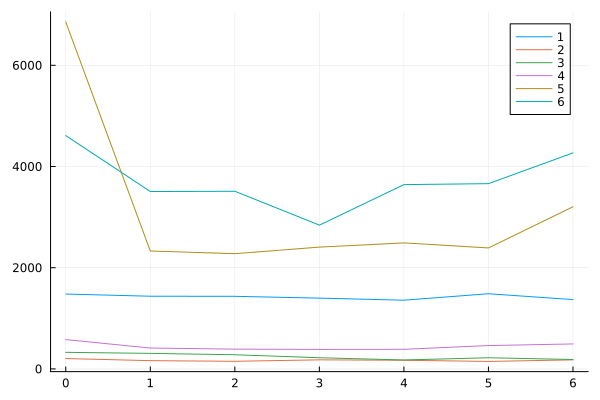

In [7]:
using Plots

p = plot()
for subset_idx = 1:6
    plot!(p, 0:6, min_plls[subset_idx,:], label="$(subset_idx)")
end
display(p)

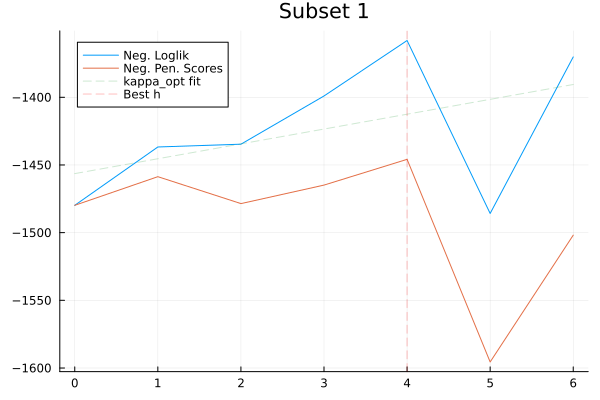

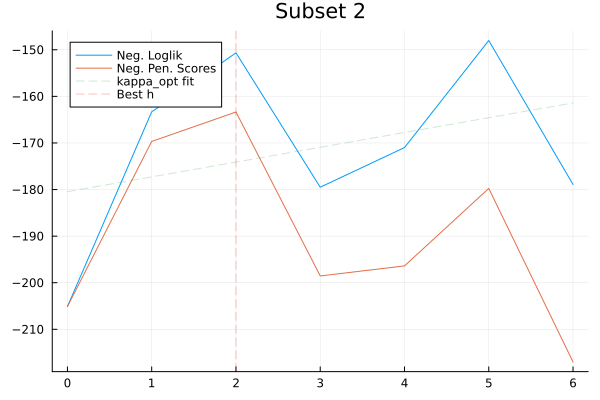

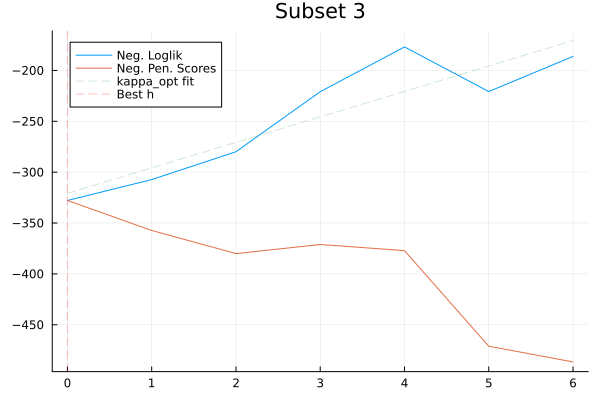

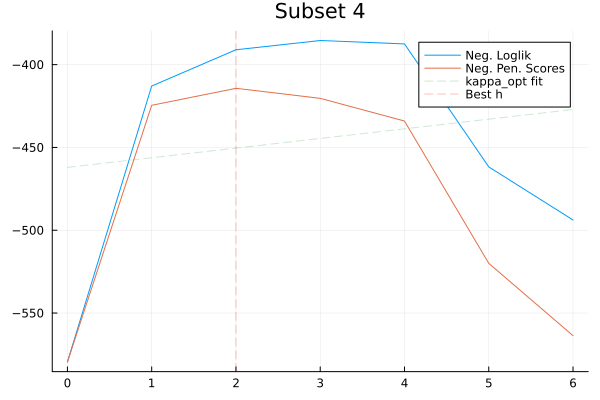

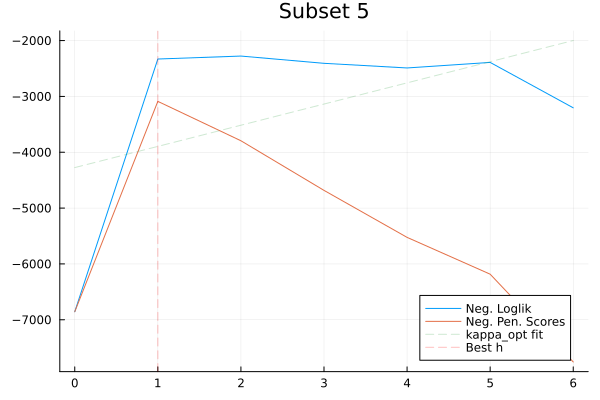

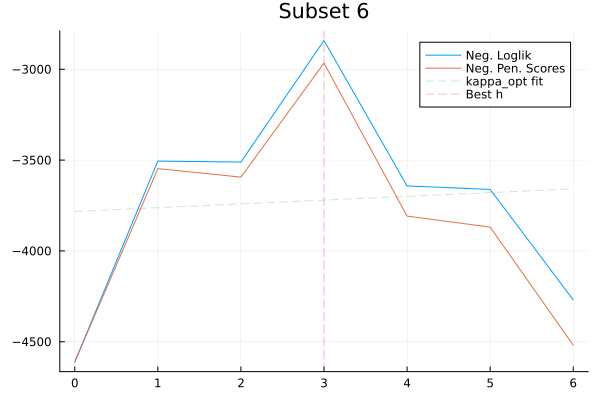

In [8]:
# Plot nll curves
for subset_idx = 1:6
    p = plot_model_selection(collect(0:6), .-min_plls[subset_idx, :])
    title!(p, "Subset $(subset_idx)")
    display(p)
end

In [29]:
# Select `h` values
gymno_cs = [
    min_constraints[j, select_model(collect(0:6), .-min_plls[j, :])[1]+1] for j=1:6
];
println([h.gamma for h in reduce(vcat, [[getparentedge(H) for H in c.hybrid] for c in gymno_cs])])
for c in gymno_cs
    while length(c.node[c.root].edge) != 2
        try
            rootatnode!(c, getchildren(c.node[c.root])[1])
        catch e
            rootatnode!(c, getchildren(c.node[c.root])[2])
        end
    end
end

# Check GoF of just this gymnosperms portion
gymno_taxa = reduce(vcat, [tipLabels(c) for c in cs])
gymno_estgts = [pruneTruthFromDecomp(gt, gymno_taxa) for gt in est_gts]
gymno_tre0 = pruneTruthFromDecomp(best_species_tree, gymno_taxa)
gymno_D, gymno_namelist = calculateAGID(gymno_estgts)
gymno_mnet = inphynet(gymno_D, gymno_cs, gymno_namelist)

[0.8373672593145361, 0.9586919995368537, 0.9886232517050132, 0.9670043671794365, 0.9893650872289079, 0.9908875288106126, 0.9262798965121195, 0.8942240994411662, 0.6256026289143799, 0.5815957192696626, 0.6570869195179994, 0.5611120390116231]


In [28]:
gymno_mnet_coded = deepcopy(gymno_mnet)
for (j, leaf) in enumerate(gymno_mnet_coded.leaf)
    leaf.name = filter(r -> r.Code == leaf.name, annot_df)[1,"brief_Classification"]
    leaf.name = "$(leaf.name)_$(j)"
end
println(writeTopology(gymno_mnet_coded))

(((((((((((Pinales_71,Pinales_72),Pinales_73),((((((Pinales_59,((((((Pinales_1,Pinales_2),Pinales_3),Pinales_4),(((((Pinales_5,(Pinales_6)#H10),((Pinales_8,(Pinales_7)#H12),(Pinales_9,#H12))),(Pinales_10,#H10)),(Pinales_11,Pinales_12)),(((((Pinales_13,((Pinales_15,Pinales_16),(Pinales_14)#H6)),(((Pinales_17,(Pinales_18)#H11),(Pinales_19,Pinales_20)),#H11)),Pinales_21),Pinales_22),(Pinales_23,#H6)))),((((Gnetales_56,Gnetales_57),Gnetales_58),((((((Cycadales Cycadales_51,Cycadales Cycadales_52),Cycadales Cycadales_53),Cycadales Cycadales_54),Ginkgoales Ginkgoales_55),((((((BasalAngiosperms_39,(BasalAngiosperms_40,BasalAngiosperms_41)),(BasalAngiosperms_42,BasalAngiosperms_43)),BasalAngiosperms_44),((Lycophytes_45,(Lycophytes_46,Lycophytes_47)),(LeptosporangiateMonilophytes_48,(LeptosporangiateMonilophytes_49,LeptosporangiateMonilophytes_50)))),#H7))#H5),#H5)),(((((Pinales_36,Pinales_37),(Pinales_38,#H9)),((Pinales_30,(((Pinales_31,(Pinales_32,Pinales_33)),Pinales_34),Pinales_35)))#H9),((

In [3]:
# Infer huge network w/ InPhyNet
D, namelist = calculateAGID(est_gts)


([0.0 0.4440113157547871 … 1.2108721540060927 1.378638815470912; 0.4440113157547871 0.0 … 1.4418369665771766 1.6452616059081902; … ; 1.2108721540060927 1.4418369665771766 … 0.0 1.1610485102018648; 1.378638815470912 1.6452616059081902 … 1.1610485102018648 0.0], ["AALA", "AAXJ", "ABCD", "ABEH", "ABIJ", "ABSS", "ACFP", "ACRY", "ACWS", "ADHK"  …  "ZSSR", "ZTHV", "ZTLR", "ZUHO", "ZULJ", "ZXJO", "ZYAX", "ZYCD", "ZZEI", "ZZOL"])

In [5]:
using Plots, StatsPlots
hD = deepcopy(D)
for j=1:size(hD, 1)
    hD[j,j] = -1.0
end
histogram(D[D .>= 0])